# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

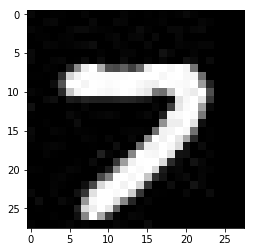

In [2]:
show_n_images = 1

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

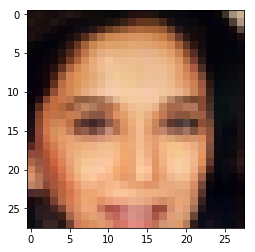

In [3]:
show_n_images = 1

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # images shape 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4#256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))
    # Adding a smoothing factor to prevent discriminator from being "too efficient"
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    
    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph() we calling the func in tf.Graph().as_default()
    out_channel_dim = data_shape[3]
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate=learning_rate, beta1=beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images *= 2.0
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 15, input_z, out_channel_dim, data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.8421... Generator Loss: 0.3847
Epoch 0/2... Discriminator Loss: 0.5860... Generator Loss: 7.9209
Epoch 0/2... Discriminator Loss: 0.4621... Generator Loss: 7.9826
Epoch 0/2... Discriminator Loss: 2.7266... Generator Loss: 0.2026
Epoch 0/2... Discriminator Loss: 0.5137... Generator Loss: 3.1660
Epoch 0/2... Discriminator Loss: 0.5966... Generator Loss: 1.8522
Epoch 0/2... Discriminator Loss: 1.2908... Generator Loss: 0.5713
Epoch 0/2... Discriminator Loss: 0.5697... Generator Loss: 2.6405
Epoch 0/2... Discriminator Loss: 1.9101... Generator Loss: 0.8787
Epoch 0/2... Discriminator Loss: 0.7417... Generator Loss: 1.7996


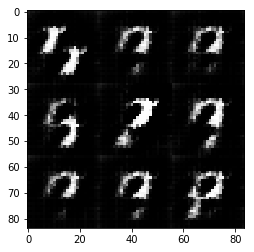

Epoch 0/2... Discriminator Loss: 0.7937... Generator Loss: 3.0329
Epoch 0/2... Discriminator Loss: 1.0782... Generator Loss: 1.0593
Epoch 0/2... Discriminator Loss: 0.8302... Generator Loss: 1.7296
Epoch 0/2... Discriminator Loss: 0.5870... Generator Loss: 2.4468
Epoch 0/2... Discriminator Loss: 0.6215... Generator Loss: 2.7750
Epoch 0/2... Discriminator Loss: 0.7755... Generator Loss: 4.3597
Epoch 0/2... Discriminator Loss: 0.7500... Generator Loss: 2.0332
Epoch 0/2... Discriminator Loss: 0.8641... Generator Loss: 2.2184
Epoch 0/2... Discriminator Loss: 0.8732... Generator Loss: 2.6443
Epoch 0/2... Discriminator Loss: 0.7956... Generator Loss: 1.4956


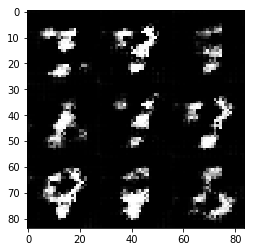

Epoch 0/2... Discriminator Loss: 0.9013... Generator Loss: 1.0937
Epoch 0/2... Discriminator Loss: 0.8461... Generator Loss: 3.3153
Epoch 0/2... Discriminator Loss: 0.7463... Generator Loss: 3.0072
Epoch 0/2... Discriminator Loss: 1.2860... Generator Loss: 2.5370
Epoch 0/2... Discriminator Loss: 0.7670... Generator Loss: 1.3476
Epoch 0/2... Discriminator Loss: 0.8613... Generator Loss: 2.0189
Epoch 0/2... Discriminator Loss: 0.7196... Generator Loss: 2.4936
Epoch 0/2... Discriminator Loss: 1.3372... Generator Loss: 0.6092
Epoch 0/2... Discriminator Loss: 0.9083... Generator Loss: 1.7455
Epoch 0/2... Discriminator Loss: 1.1717... Generator Loss: 0.8211


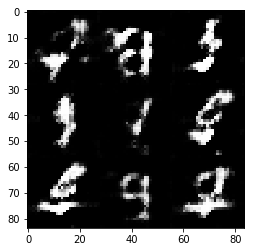

Epoch 0/2... Discriminator Loss: 1.3980... Generator Loss: 0.5663
Epoch 0/2... Discriminator Loss: 0.9198... Generator Loss: 1.4561
Epoch 0/2... Discriminator Loss: 0.8123... Generator Loss: 2.1178
Epoch 0/2... Discriminator Loss: 1.0576... Generator Loss: 0.9266
Epoch 0/2... Discriminator Loss: 1.0592... Generator Loss: 1.9545
Epoch 0/2... Discriminator Loss: 1.0849... Generator Loss: 1.5506
Epoch 0/2... Discriminator Loss: 0.8723... Generator Loss: 1.6408
Epoch 0/2... Discriminator Loss: 0.9746... Generator Loss: 1.7069
Epoch 0/2... Discriminator Loss: 1.0219... Generator Loss: 1.0412
Epoch 0/2... Discriminator Loss: 0.9686... Generator Loss: 1.7272


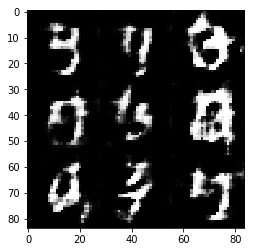

Epoch 0/2... Discriminator Loss: 1.0368... Generator Loss: 1.5944
Epoch 0/2... Discriminator Loss: 1.1642... Generator Loss: 0.8059
Epoch 0/2... Discriminator Loss: 1.3328... Generator Loss: 0.7047
Epoch 0/2... Discriminator Loss: 0.9354... Generator Loss: 1.3144
Epoch 0/2... Discriminator Loss: 0.9275... Generator Loss: 1.1518
Epoch 0/2... Discriminator Loss: 1.0076... Generator Loss: 1.7860
Epoch 0/2... Discriminator Loss: 0.8859... Generator Loss: 1.4631
Epoch 0/2... Discriminator Loss: 0.9948... Generator Loss: 1.0013
Epoch 0/2... Discriminator Loss: 1.1734... Generator Loss: 1.5149
Epoch 0/2... Discriminator Loss: 1.1290... Generator Loss: 1.8163


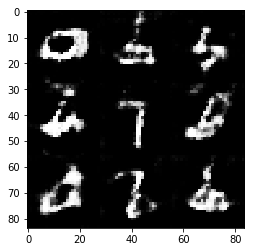

Epoch 0/2... Discriminator Loss: 1.1830... Generator Loss: 0.7768
Epoch 0/2... Discriminator Loss: 1.1315... Generator Loss: 1.6414
Epoch 0/2... Discriminator Loss: 1.1695... Generator Loss: 0.7351
Epoch 0/2... Discriminator Loss: 1.0280... Generator Loss: 1.1561
Epoch 0/2... Discriminator Loss: 1.1290... Generator Loss: 1.3122
Epoch 0/2... Discriminator Loss: 1.1250... Generator Loss: 1.3062
Epoch 0/2... Discriminator Loss: 1.5572... Generator Loss: 0.5541
Epoch 0/2... Discriminator Loss: 1.1492... Generator Loss: 1.1954
Epoch 0/2... Discriminator Loss: 1.1215... Generator Loss: 1.1616
Epoch 0/2... Discriminator Loss: 1.0857... Generator Loss: 1.1108


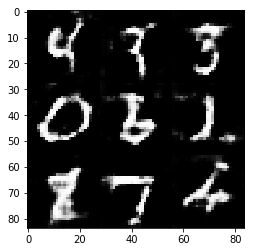

Epoch 0/2... Discriminator Loss: 1.0817... Generator Loss: 0.8248
Epoch 0/2... Discriminator Loss: 1.2447... Generator Loss: 0.6808
Epoch 0/2... Discriminator Loss: 1.1774... Generator Loss: 1.3585
Epoch 0/2... Discriminator Loss: 1.0150... Generator Loss: 1.2436
Epoch 0/2... Discriminator Loss: 1.1522... Generator Loss: 0.8422
Epoch 0/2... Discriminator Loss: 1.1294... Generator Loss: 0.8286
Epoch 0/2... Discriminator Loss: 1.0461... Generator Loss: 1.3951
Epoch 0/2... Discriminator Loss: 1.2313... Generator Loss: 0.8502
Epoch 0/2... Discriminator Loss: 1.2726... Generator Loss: 1.7536
Epoch 0/2... Discriminator Loss: 1.1130... Generator Loss: 1.3444


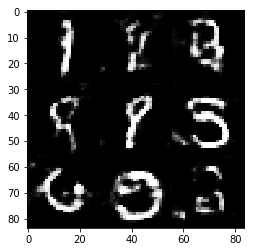

Epoch 0/2... Discriminator Loss: 1.1876... Generator Loss: 0.9988
Epoch 0/2... Discriminator Loss: 1.3090... Generator Loss: 0.6086
Epoch 0/2... Discriminator Loss: 1.1484... Generator Loss: 1.4217
Epoch 0/2... Discriminator Loss: 1.0900... Generator Loss: 0.9987
Epoch 0/2... Discriminator Loss: 1.1007... Generator Loss: 0.7668
Epoch 0/2... Discriminator Loss: 1.2659... Generator Loss: 0.7568
Epoch 0/2... Discriminator Loss: 1.0166... Generator Loss: 1.2956
Epoch 0/2... Discriminator Loss: 1.0761... Generator Loss: 0.9022
Epoch 0/2... Discriminator Loss: 1.1074... Generator Loss: 1.0446
Epoch 0/2... Discriminator Loss: 1.7313... Generator Loss: 0.3555


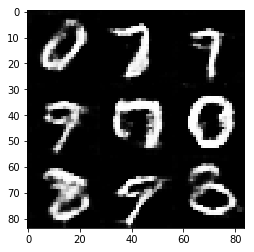

Epoch 0/2... Discriminator Loss: 0.9926... Generator Loss: 1.3367
Epoch 0/2... Discriminator Loss: 1.1113... Generator Loss: 0.8472
Epoch 0/2... Discriminator Loss: 1.1855... Generator Loss: 0.8699
Epoch 0/2... Discriminator Loss: 1.1304... Generator Loss: 1.0283
Epoch 0/2... Discriminator Loss: 1.2988... Generator Loss: 1.6566
Epoch 0/2... Discriminator Loss: 1.2536... Generator Loss: 0.6597
Epoch 0/2... Discriminator Loss: 1.1033... Generator Loss: 1.3877
Epoch 0/2... Discriminator Loss: 1.3512... Generator Loss: 1.9250
Epoch 0/2... Discriminator Loss: 1.1072... Generator Loss: 0.8607
Epoch 0/2... Discriminator Loss: 2.0888... Generator Loss: 0.2326


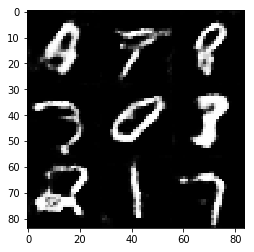

Epoch 0/2... Discriminator Loss: 1.0331... Generator Loss: 1.1175
Epoch 0/2... Discriminator Loss: 1.2132... Generator Loss: 2.2551
Epoch 0/2... Discriminator Loss: 1.1964... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.2462
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 2.5135
Epoch 1/2... Discriminator Loss: 1.0894... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.1106... Generator Loss: 0.8379
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.9377


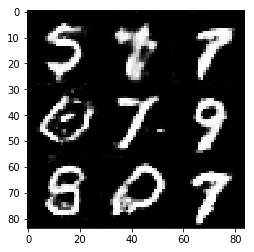

Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 1.2318
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.3722
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.5782
Epoch 1/2... Discriminator Loss: 1.4914... Generator Loss: 1.7487
Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 1.1089
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 0.8835
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.0347
Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 0.4291
Epoch 1/2... Discriminator Loss: 1.6664... Generator Loss: 0.3827


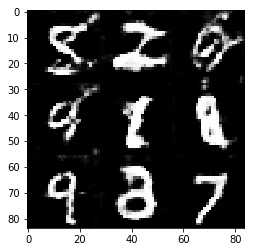

Epoch 1/2... Discriminator Loss: 1.5478... Generator Loss: 2.2619
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 1.6448
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.0879
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 1.5949
Epoch 1/2... Discriminator Loss: 1.9473... Generator Loss: 3.0475
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 1.5563
Epoch 1/2... Discriminator Loss: 1.6494... Generator Loss: 2.3013


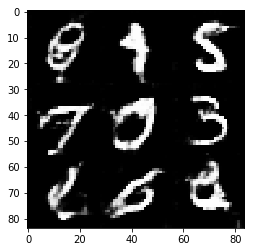

Epoch 1/2... Discriminator Loss: 1.0999... Generator Loss: 1.1606
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.9685
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 1.6519
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.4421
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 1.4028
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.5469
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 1.0429


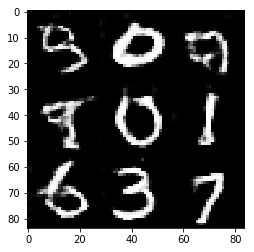

Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 1.2989
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 1.6565
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 1.4582
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 1.1058
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.9484
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 2.1156... Generator Loss: 0.2285
Epoch 1/2... Discriminator Loss: 1.2387... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 1.0087


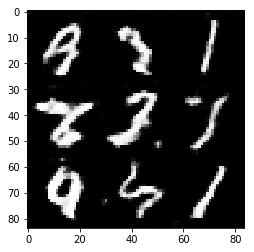

Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.6086
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 1.4555
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.4867
Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 0.9213
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 1.0156
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.0185
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 1.2667
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 1.5310
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 2.0808


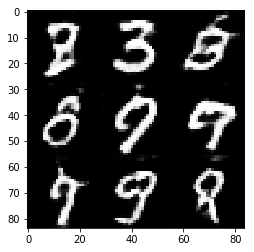

Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.3029
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 1.2870
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.6328
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 1.5734
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 1.5005


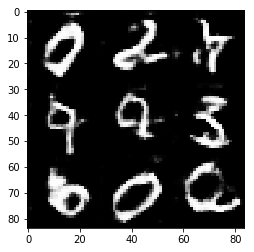

Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.5816... Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 0.8059... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 1.7264... Generator Loss: 3.0517
Epoch 1/2... Discriminator Loss: 1.7737... Generator Loss: 0.3651
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 1.6249
Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 1.0683
Epoch 1/2... Discriminator Loss: 2.4647... Generator Loss: 0.1685
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.7547
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 1.7721


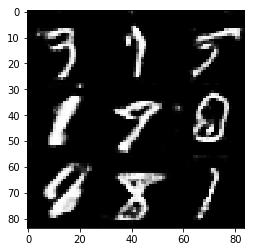

Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.5583
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 1.6671... Generator Loss: 0.3822
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 1.5061
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 0.9483
Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 1.0329


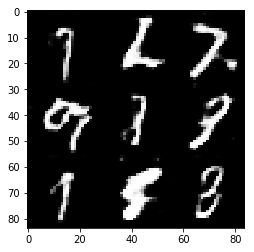

Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 1.0313
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 1.9516... Generator Loss: 3.1004
Epoch 1/2... Discriminator Loss: 1.5929... Generator Loss: 0.4451
Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 1.3342
Epoch 1/2... Discriminator Loss: 1.6514... Generator Loss: 0.4226


In [13]:
import math
batch_size = 64
z_dim = 100
learning_rate = (math.e * 2) ** (-4)
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.6277... Generator Loss: 10.9320
Epoch 0/1... Discriminator Loss: 2.2651... Generator Loss: 0.5034
Epoch 0/1... Discriminator Loss: 0.7080... Generator Loss: 2.7332
Epoch 0/1... Discriminator Loss: 0.9395... Generator Loss: 2.9590
Epoch 0/1... Discriminator Loss: 1.0378... Generator Loss: 1.5172
Epoch 0/1... Discriminator Loss: 0.9837... Generator Loss: 3.1231
Epoch 0/1... Discriminator Loss: 0.6853... Generator Loss: 2.6182
Epoch 0/1... Discriminator Loss: 0.6427... Generator Loss: 2.8378
Epoch 0/1... Discriminator Loss: 1.1262... Generator Loss: 4.5217
Epoch 0/1... Discriminator Loss: 0.9515... Generator Loss: 1.2439


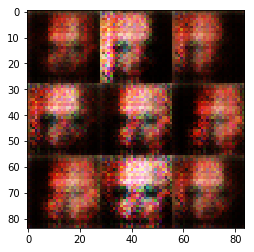

Epoch 0/1... Discriminator Loss: 1.0398... Generator Loss: 1.4722
Epoch 0/1... Discriminator Loss: 1.6251... Generator Loss: 0.5171
Epoch 0/1... Discriminator Loss: 0.9921... Generator Loss: 1.0414
Epoch 0/1... Discriminator Loss: 1.4890... Generator Loss: 0.7123
Epoch 0/1... Discriminator Loss: 1.3767... Generator Loss: 0.8341
Epoch 0/1... Discriminator Loss: 1.8880... Generator Loss: 0.3922
Epoch 0/1... Discriminator Loss: 1.4209... Generator Loss: 0.9078
Epoch 0/1... Discriminator Loss: 1.3586... Generator Loss: 1.0299
Epoch 0/1... Discriminator Loss: 1.3127... Generator Loss: 1.3572
Epoch 0/1... Discriminator Loss: 1.5237... Generator Loss: 0.6401


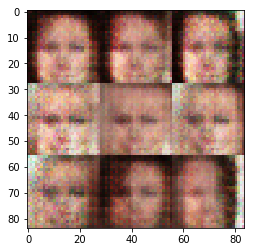

Epoch 0/1... Discriminator Loss: 1.3410... Generator Loss: 0.7556
Epoch 0/1... Discriminator Loss: 1.6091... Generator Loss: 1.0637
Epoch 0/1... Discriminator Loss: 1.1748... Generator Loss: 0.8068
Epoch 0/1... Discriminator Loss: 1.2809... Generator Loss: 0.8133
Epoch 0/1... Discriminator Loss: 1.2465... Generator Loss: 0.9706
Epoch 0/1... Discriminator Loss: 1.5003... Generator Loss: 0.5619
Epoch 0/1... Discriminator Loss: 1.2368... Generator Loss: 0.7804
Epoch 0/1... Discriminator Loss: 1.2512... Generator Loss: 1.2239
Epoch 0/1... Discriminator Loss: 1.2664... Generator Loss: 1.0174
Epoch 0/1... Discriminator Loss: 1.3355... Generator Loss: 0.7184


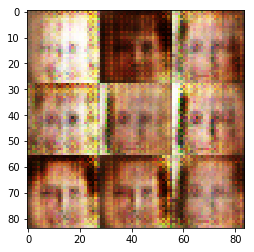

Epoch 0/1... Discriminator Loss: 1.3096... Generator Loss: 0.8297
Epoch 0/1... Discriminator Loss: 1.3938... Generator Loss: 0.8571
Epoch 0/1... Discriminator Loss: 1.5290... Generator Loss: 0.8178
Epoch 0/1... Discriminator Loss: 1.2619... Generator Loss: 1.0158
Epoch 0/1... Discriminator Loss: 1.2379... Generator Loss: 0.8653
Epoch 0/1... Discriminator Loss: 1.2881... Generator Loss: 0.9171
Epoch 0/1... Discriminator Loss: 1.3546... Generator Loss: 0.7540
Epoch 0/1... Discriminator Loss: 1.1929... Generator Loss: 1.5036
Epoch 0/1... Discriminator Loss: 1.3536... Generator Loss: 1.0436
Epoch 0/1... Discriminator Loss: 1.4112... Generator Loss: 0.7711


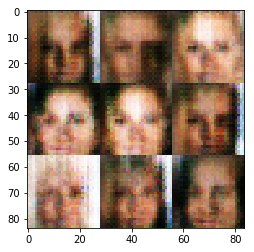

Epoch 0/1... Discriminator Loss: 1.3489... Generator Loss: 0.9122
Epoch 0/1... Discriminator Loss: 1.3183... Generator Loss: 0.6768
Epoch 0/1... Discriminator Loss: 1.3457... Generator Loss: 0.8308
Epoch 0/1... Discriminator Loss: 1.3804... Generator Loss: 0.6801
Epoch 0/1... Discriminator Loss: 1.4293... Generator Loss: 0.6164
Epoch 0/1... Discriminator Loss: 1.0474... Generator Loss: 1.5546
Epoch 0/1... Discriminator Loss: 1.2565... Generator Loss: 0.7843
Epoch 0/1... Discriminator Loss: 1.1825... Generator Loss: 0.8520
Epoch 0/1... Discriminator Loss: 1.2073... Generator Loss: 0.8121
Epoch 0/1... Discriminator Loss: 1.7903... Generator Loss: 0.3361


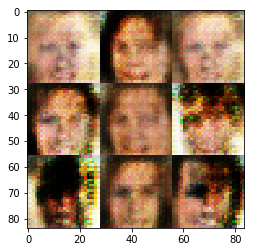

Epoch 0/1... Discriminator Loss: 1.2439... Generator Loss: 0.8879
Epoch 0/1... Discriminator Loss: 1.1697... Generator Loss: 0.8471
Epoch 0/1... Discriminator Loss: 1.4134... Generator Loss: 0.6194
Epoch 0/1... Discriminator Loss: 1.6094... Generator Loss: 0.9217
Epoch 0/1... Discriminator Loss: 1.2141... Generator Loss: 1.1957
Epoch 0/1... Discriminator Loss: 1.4029... Generator Loss: 0.5493
Epoch 0/1... Discriminator Loss: 1.3221... Generator Loss: 1.2823
Epoch 0/1... Discriminator Loss: 1.0600... Generator Loss: 1.0411
Epoch 0/1... Discriminator Loss: 1.2342... Generator Loss: 0.9286
Epoch 0/1... Discriminator Loss: 1.7295... Generator Loss: 0.3820


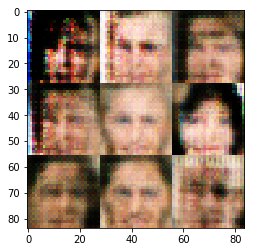

Epoch 0/1... Discriminator Loss: 1.3404... Generator Loss: 0.8437
Epoch 0/1... Discriminator Loss: 1.3652... Generator Loss: 0.6440
Epoch 0/1... Discriminator Loss: 1.4999... Generator Loss: 0.4720
Epoch 0/1... Discriminator Loss: 1.5772... Generator Loss: 0.4764
Epoch 0/1... Discriminator Loss: 1.2133... Generator Loss: 1.8616
Epoch 0/1... Discriminator Loss: 1.2720... Generator Loss: 0.8432
Epoch 0/1... Discriminator Loss: 1.4191... Generator Loss: 0.5474
Epoch 0/1... Discriminator Loss: 1.3119... Generator Loss: 0.7630
Epoch 0/1... Discriminator Loss: 1.4033... Generator Loss: 0.7734
Epoch 0/1... Discriminator Loss: 1.1877... Generator Loss: 0.6881


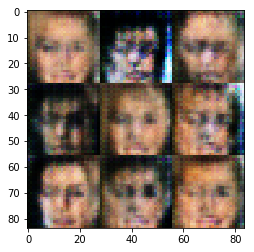

Epoch 0/1... Discriminator Loss: 1.8383... Generator Loss: 2.2228
Epoch 0/1... Discriminator Loss: 1.0116... Generator Loss: 1.2561
Epoch 0/1... Discriminator Loss: 1.1899... Generator Loss: 0.8468
Epoch 0/1... Discriminator Loss: 1.3537... Generator Loss: 0.8004
Epoch 0/1... Discriminator Loss: 1.1708... Generator Loss: 0.7716
Epoch 0/1... Discriminator Loss: 1.3541... Generator Loss: 0.6550
Epoch 0/1... Discriminator Loss: 1.1587... Generator Loss: 0.7746
Epoch 0/1... Discriminator Loss: 1.0001... Generator Loss: 1.2344
Epoch 0/1... Discriminator Loss: 1.1887... Generator Loss: 1.1791
Epoch 0/1... Discriminator Loss: 1.1096... Generator Loss: 1.5239


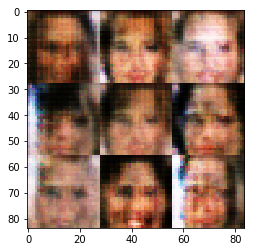

Epoch 0/1... Discriminator Loss: 1.2776... Generator Loss: 0.6759
Epoch 0/1... Discriminator Loss: 1.9179... Generator Loss: 2.4252
Epoch 0/1... Discriminator Loss: 1.3361... Generator Loss: 2.0540
Epoch 0/1... Discriminator Loss: 1.2920... Generator Loss: 0.6196
Epoch 0/1... Discriminator Loss: 1.4885... Generator Loss: 0.8512
Epoch 0/1... Discriminator Loss: 1.3996... Generator Loss: 0.8300
Epoch 0/1... Discriminator Loss: 1.2399... Generator Loss: 0.8774
Epoch 0/1... Discriminator Loss: 1.2061... Generator Loss: 1.3388
Epoch 0/1... Discriminator Loss: 1.2048... Generator Loss: 0.9697
Epoch 0/1... Discriminator Loss: 1.1862... Generator Loss: 1.0096


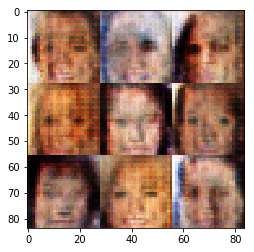

Epoch 0/1... Discriminator Loss: 1.3744... Generator Loss: 0.6181
Epoch 0/1... Discriminator Loss: 1.4098... Generator Loss: 0.8478
Epoch 0/1... Discriminator Loss: 1.4302... Generator Loss: 0.5132
Epoch 0/1... Discriminator Loss: 1.1945... Generator Loss: 1.2531
Epoch 0/1... Discriminator Loss: 1.0484... Generator Loss: 0.9312
Epoch 0/1... Discriminator Loss: 1.2562... Generator Loss: 0.7926
Epoch 0/1... Discriminator Loss: 1.1212... Generator Loss: 0.9344
Epoch 0/1... Discriminator Loss: 1.2465... Generator Loss: 0.7875
Epoch 0/1... Discriminator Loss: 1.2235... Generator Loss: 0.7150
Epoch 0/1... Discriminator Loss: 1.4349... Generator Loss: 0.6951


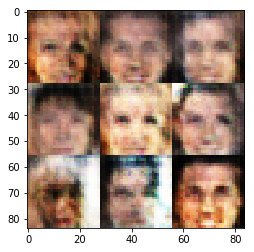

Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 1.1703
Epoch 0/1... Discriminator Loss: 1.4683... Generator Loss: 0.5758
Epoch 0/1... Discriminator Loss: 1.1449... Generator Loss: 0.9625
Epoch 0/1... Discriminator Loss: 1.0797... Generator Loss: 0.9770
Epoch 0/1... Discriminator Loss: 1.2538... Generator Loss: 1.6504
Epoch 0/1... Discriminator Loss: 1.3339... Generator Loss: 1.6255
Epoch 0/1... Discriminator Loss: 1.2728... Generator Loss: 1.2224
Epoch 0/1... Discriminator Loss: 1.3337... Generator Loss: 0.6210
Epoch 0/1... Discriminator Loss: 1.4071... Generator Loss: 1.4866
Epoch 0/1... Discriminator Loss: 1.1295... Generator Loss: 1.0373


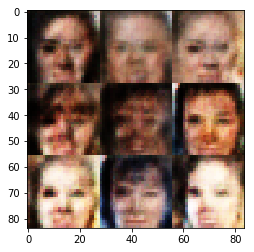

Epoch 0/1... Discriminator Loss: 1.1510... Generator Loss: 1.0384
Epoch 0/1... Discriminator Loss: 1.2424... Generator Loss: 1.3354
Epoch 0/1... Discriminator Loss: 1.1094... Generator Loss: 1.0819
Epoch 0/1... Discriminator Loss: 1.2098... Generator Loss: 0.8608
Epoch 0/1... Discriminator Loss: 1.2553... Generator Loss: 1.3904
Epoch 0/1... Discriminator Loss: 1.2694... Generator Loss: 0.6682
Epoch 0/1... Discriminator Loss: 1.3734... Generator Loss: 1.8229
Epoch 0/1... Discriminator Loss: 1.5287... Generator Loss: 0.4423
Epoch 0/1... Discriminator Loss: 1.3531... Generator Loss: 0.6426
Epoch 0/1... Discriminator Loss: 1.1935... Generator Loss: 1.4322


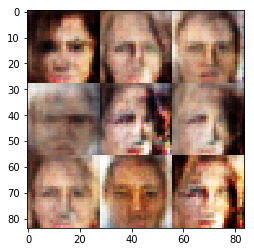

Epoch 0/1... Discriminator Loss: 1.2563... Generator Loss: 0.6793
Epoch 0/1... Discriminator Loss: 1.5020... Generator Loss: 1.6600
Epoch 0/1... Discriminator Loss: 1.2121... Generator Loss: 0.7707
Epoch 0/1... Discriminator Loss: 1.2265... Generator Loss: 1.0597
Epoch 0/1... Discriminator Loss: 1.5194... Generator Loss: 0.4743
Epoch 0/1... Discriminator Loss: 1.2227... Generator Loss: 1.2525
Epoch 0/1... Discriminator Loss: 1.2654... Generator Loss: 0.6618
Epoch 0/1... Discriminator Loss: 1.3374... Generator Loss: 0.6087
Epoch 0/1... Discriminator Loss: 1.2230... Generator Loss: 1.4139
Epoch 0/1... Discriminator Loss: 1.3358... Generator Loss: 0.6249


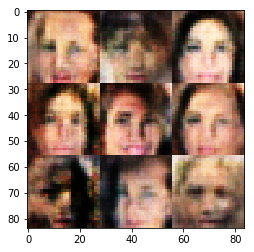

Epoch 0/1... Discriminator Loss: 1.3669... Generator Loss: 0.7204
Epoch 0/1... Discriminator Loss: 1.2314... Generator Loss: 0.9532
Epoch 0/1... Discriminator Loss: 1.1874... Generator Loss: 0.8903
Epoch 0/1... Discriminator Loss: 1.2202... Generator Loss: 0.8431
Epoch 0/1... Discriminator Loss: 1.1742... Generator Loss: 0.9589
Epoch 0/1... Discriminator Loss: 1.2232... Generator Loss: 1.0983
Epoch 0/1... Discriminator Loss: 1.3036... Generator Loss: 0.6708
Epoch 0/1... Discriminator Loss: 1.3725... Generator Loss: 1.7813
Epoch 0/1... Discriminator Loss: 1.3463... Generator Loss: 0.7852
Epoch 0/1... Discriminator Loss: 1.2492... Generator Loss: 0.6275


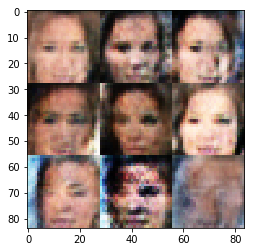

Epoch 0/1... Discriminator Loss: 1.3481... Generator Loss: 1.2575
Epoch 0/1... Discriminator Loss: 1.2850... Generator Loss: 0.7667
Epoch 0/1... Discriminator Loss: 1.2167... Generator Loss: 0.7596
Epoch 0/1... Discriminator Loss: 1.2199... Generator Loss: 0.9487
Epoch 0/1... Discriminator Loss: 1.4731... Generator Loss: 0.4785
Epoch 0/1... Discriminator Loss: 1.1824... Generator Loss: 0.8080
Epoch 0/1... Discriminator Loss: 1.3136... Generator Loss: 0.6228
Epoch 0/1... Discriminator Loss: 1.2098... Generator Loss: 0.8373
Epoch 0/1... Discriminator Loss: 1.1330... Generator Loss: 1.6878
Epoch 0/1... Discriminator Loss: 1.1959... Generator Loss: 1.1850


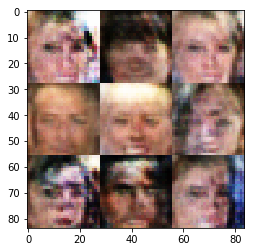

Epoch 0/1... Discriminator Loss: 1.6510... Generator Loss: 0.3604
Epoch 0/1... Discriminator Loss: 1.1741... Generator Loss: 0.7722
Epoch 0/1... Discriminator Loss: 1.2944... Generator Loss: 0.7382
Epoch 0/1... Discriminator Loss: 1.2870... Generator Loss: 0.6701
Epoch 0/1... Discriminator Loss: 1.3537... Generator Loss: 0.6016
Epoch 0/1... Discriminator Loss: 1.6218... Generator Loss: 0.3882
Epoch 0/1... Discriminator Loss: 1.2770... Generator Loss: 1.2554
Epoch 0/1... Discriminator Loss: 1.2470... Generator Loss: 1.2012
Epoch 0/1... Discriminator Loss: 1.2556... Generator Loss: 1.1317
Epoch 0/1... Discriminator Loss: 1.1809... Generator Loss: 1.1081


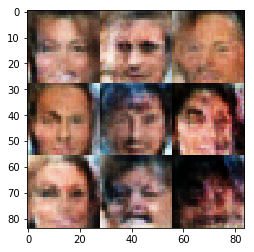

Epoch 0/1... Discriminator Loss: 1.2472... Generator Loss: 1.4564
Epoch 0/1... Discriminator Loss: 1.2438... Generator Loss: 1.3829
Epoch 0/1... Discriminator Loss: 1.2594... Generator Loss: 1.5606
Epoch 0/1... Discriminator Loss: 1.1965... Generator Loss: 0.7161
Epoch 0/1... Discriminator Loss: 1.1972... Generator Loss: 1.0917
Epoch 0/1... Discriminator Loss: 1.0446... Generator Loss: 1.1615
Epoch 0/1... Discriminator Loss: 1.2331... Generator Loss: 1.1339
Epoch 0/1... Discriminator Loss: 1.2195... Generator Loss: 1.7599
Epoch 0/1... Discriminator Loss: 1.1840... Generator Loss: 0.8397
Epoch 0/1... Discriminator Loss: 1.3298... Generator Loss: 0.7067


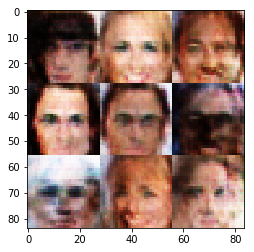

Epoch 0/1... Discriminator Loss: 1.1114... Generator Loss: 1.0367
Epoch 0/1... Discriminator Loss: 1.2167... Generator Loss: 0.8572
Epoch 0/1... Discriminator Loss: 1.1779... Generator Loss: 1.6641
Epoch 0/1... Discriminator Loss: 1.2455... Generator Loss: 0.9634
Epoch 0/1... Discriminator Loss: 1.3428... Generator Loss: 0.5432
Epoch 0/1... Discriminator Loss: 1.2316... Generator Loss: 1.4916
Epoch 0/1... Discriminator Loss: 1.2316... Generator Loss: 1.3807
Epoch 0/1... Discriminator Loss: 1.1639... Generator Loss: 1.3186
Epoch 0/1... Discriminator Loss: 1.1637... Generator Loss: 0.9179
Epoch 0/1... Discriminator Loss: 1.1715... Generator Loss: 1.1327


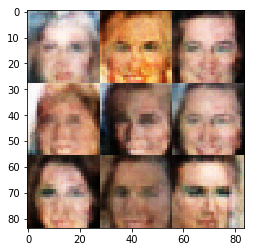

Epoch 0/1... Discriminator Loss: 1.1733... Generator Loss: 1.0917
Epoch 0/1... Discriminator Loss: 1.1545... Generator Loss: 1.0189
Epoch 0/1... Discriminator Loss: 1.3991... Generator Loss: 1.8843
Epoch 0/1... Discriminator Loss: 1.1677... Generator Loss: 0.8284
Epoch 0/1... Discriminator Loss: 1.6698... Generator Loss: 2.2725
Epoch 0/1... Discriminator Loss: 1.2080... Generator Loss: 0.8051
Epoch 0/1... Discriminator Loss: 1.1752... Generator Loss: 1.4715
Epoch 0/1... Discriminator Loss: 1.2510... Generator Loss: 0.6822
Epoch 0/1... Discriminator Loss: 1.1872... Generator Loss: 1.3672
Epoch 0/1... Discriminator Loss: 1.1833... Generator Loss: 0.7121


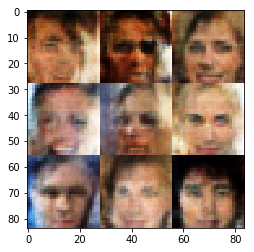

Epoch 0/1... Discriminator Loss: 1.3167... Generator Loss: 0.5693
Epoch 0/1... Discriminator Loss: 1.6011... Generator Loss: 0.3886
Epoch 0/1... Discriminator Loss: 1.2056... Generator Loss: 1.0692
Epoch 0/1... Discriminator Loss: 1.2125... Generator Loss: 0.8474
Epoch 0/1... Discriminator Loss: 1.1562... Generator Loss: 1.0555
Epoch 0/1... Discriminator Loss: 1.1195... Generator Loss: 0.9189
Epoch 0/1... Discriminator Loss: 1.2698... Generator Loss: 0.8116
Epoch 0/1... Discriminator Loss: 1.2415... Generator Loss: 0.9796
Epoch 0/1... Discriminator Loss: 1.4811... Generator Loss: 1.7666
Epoch 0/1... Discriminator Loss: 1.1870... Generator Loss: 0.9930


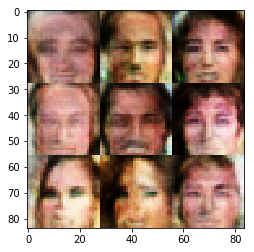

Epoch 0/1... Discriminator Loss: 1.1421... Generator Loss: 1.4350
Epoch 0/1... Discriminator Loss: 1.2466... Generator Loss: 0.7524
Epoch 0/1... Discriminator Loss: 1.1246... Generator Loss: 1.0243
Epoch 0/1... Discriminator Loss: 1.1561... Generator Loss: 1.1097
Epoch 0/1... Discriminator Loss: 1.3891... Generator Loss: 0.5816
Epoch 0/1... Discriminator Loss: 1.1098... Generator Loss: 1.0257
Epoch 0/1... Discriminator Loss: 1.3635... Generator Loss: 0.5519
Epoch 0/1... Discriminator Loss: 1.2725... Generator Loss: 1.3246
Epoch 0/1... Discriminator Loss: 1.1510... Generator Loss: 0.9924
Epoch 0/1... Discriminator Loss: 1.2681... Generator Loss: 1.4149


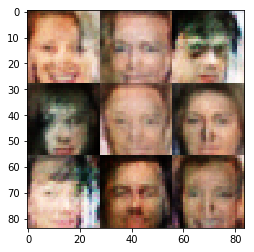

Epoch 0/1... Discriminator Loss: 1.2213... Generator Loss: 1.0875
Epoch 0/1... Discriminator Loss: 1.2054... Generator Loss: 1.5197
Epoch 0/1... Discriminator Loss: 1.0384... Generator Loss: 1.1084
Epoch 0/1... Discriminator Loss: 1.2176... Generator Loss: 0.9685
Epoch 0/1... Discriminator Loss: 1.2659... Generator Loss: 1.4225
Epoch 0/1... Discriminator Loss: 1.1927... Generator Loss: 1.0217
Epoch 0/1... Discriminator Loss: 1.2992... Generator Loss: 1.8677
Epoch 0/1... Discriminator Loss: 1.2484... Generator Loss: 1.1812
Epoch 0/1... Discriminator Loss: 1.4717... Generator Loss: 1.6364
Epoch 0/1... Discriminator Loss: 1.3256... Generator Loss: 1.1876


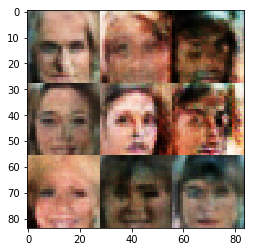

Epoch 0/1... Discriminator Loss: 1.1490... Generator Loss: 0.9323
Epoch 0/1... Discriminator Loss: 1.2888... Generator Loss: 0.8278
Epoch 0/1... Discriminator Loss: 1.2316... Generator Loss: 1.5287
Epoch 0/1... Discriminator Loss: 1.3132... Generator Loss: 0.8058
Epoch 0/1... Discriminator Loss: 1.6200... Generator Loss: 0.3793
Epoch 0/1... Discriminator Loss: 1.2551... Generator Loss: 0.8918
Epoch 0/1... Discriminator Loss: 1.1930... Generator Loss: 1.0503
Epoch 0/1... Discriminator Loss: 1.1952... Generator Loss: 0.8810
Epoch 0/1... Discriminator Loss: 1.2101... Generator Loss: 0.7399
Epoch 0/1... Discriminator Loss: 1.5217... Generator Loss: 0.4109


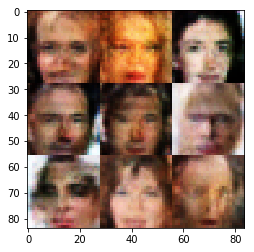

Epoch 0/1... Discriminator Loss: 1.3122... Generator Loss: 0.6108
Epoch 0/1... Discriminator Loss: 1.2832... Generator Loss: 0.6922
Epoch 0/1... Discriminator Loss: 1.1198... Generator Loss: 0.8936
Epoch 0/1... Discriminator Loss: 1.5394... Generator Loss: 0.4375
Epoch 0/1... Discriminator Loss: 1.2043... Generator Loss: 0.8563
Epoch 0/1... Discriminator Loss: 1.1582... Generator Loss: 1.3051
Epoch 0/1... Discriminator Loss: 1.0947... Generator Loss: 0.9398
Epoch 0/1... Discriminator Loss: 1.5693... Generator Loss: 0.4134
Epoch 0/1... Discriminator Loss: 1.0914... Generator Loss: 1.3771
Epoch 0/1... Discriminator Loss: 1.2715... Generator Loss: 0.7500


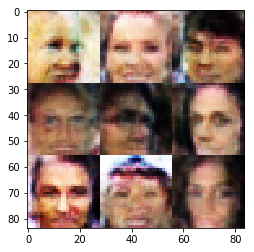

Epoch 0/1... Discriminator Loss: 1.1905... Generator Loss: 0.9732
Epoch 0/1... Discriminator Loss: 1.2962... Generator Loss: 0.7957
Epoch 0/1... Discriminator Loss: 1.2586... Generator Loss: 1.1284
Epoch 0/1... Discriminator Loss: 1.1937... Generator Loss: 1.1979
Epoch 0/1... Discriminator Loss: 1.3244... Generator Loss: 0.8548
Epoch 0/1... Discriminator Loss: 1.3590... Generator Loss: 0.5780
Epoch 0/1... Discriminator Loss: 1.2913... Generator Loss: 0.6226
Epoch 0/1... Discriminator Loss: 1.2380... Generator Loss: 0.9251
Epoch 0/1... Discriminator Loss: 1.3366... Generator Loss: 0.5908
Epoch 0/1... Discriminator Loss: 1.2710... Generator Loss: 1.4060


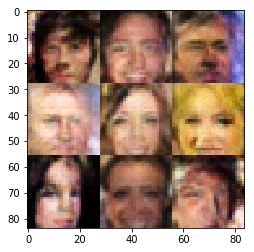

Epoch 0/1... Discriminator Loss: 1.3189... Generator Loss: 0.5748
Epoch 0/1... Discriminator Loss: 1.1996... Generator Loss: 0.8997
Epoch 0/1... Discriminator Loss: 1.2086... Generator Loss: 1.2670
Epoch 0/1... Discriminator Loss: 1.2273... Generator Loss: 1.0235
Epoch 0/1... Discriminator Loss: 1.2102... Generator Loss: 0.7682
Epoch 0/1... Discriminator Loss: 1.1180... Generator Loss: 1.0407
Epoch 0/1... Discriminator Loss: 1.2272... Generator Loss: 0.7827
Epoch 0/1... Discriminator Loss: 1.3191... Generator Loss: 0.7679
Epoch 0/1... Discriminator Loss: 1.4623... Generator Loss: 0.9995
Epoch 0/1... Discriminator Loss: 1.2234... Generator Loss: 0.8142


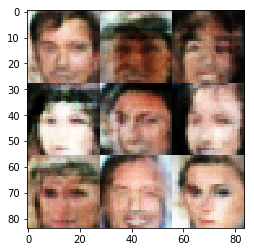

Epoch 0/1... Discriminator Loss: 1.2442... Generator Loss: 1.0230
Epoch 0/1... Discriminator Loss: 1.3106... Generator Loss: 0.8462
Epoch 0/1... Discriminator Loss: 1.1313... Generator Loss: 0.9386
Epoch 0/1... Discriminator Loss: 1.2721... Generator Loss: 1.2405
Epoch 0/1... Discriminator Loss: 1.3840... Generator Loss: 1.5876
Epoch 0/1... Discriminator Loss: 1.3495... Generator Loss: 0.5546
Epoch 0/1... Discriminator Loss: 1.6912... Generator Loss: 0.3672
Epoch 0/1... Discriminator Loss: 1.2507... Generator Loss: 0.7568
Epoch 0/1... Discriminator Loss: 1.4682... Generator Loss: 0.5056
Epoch 0/1... Discriminator Loss: 1.2036... Generator Loss: 1.0371


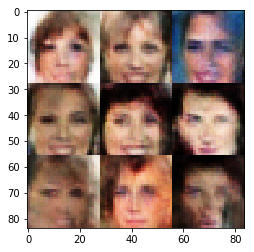

Epoch 0/1... Discriminator Loss: 1.3557... Generator Loss: 0.5776
Epoch 0/1... Discriminator Loss: 1.2378... Generator Loss: 1.1328
Epoch 0/1... Discriminator Loss: 1.2698... Generator Loss: 0.6757
Epoch 0/1... Discriminator Loss: 1.6606... Generator Loss: 0.3845
Epoch 0/1... Discriminator Loss: 1.5080... Generator Loss: 0.4124
Epoch 0/1... Discriminator Loss: 1.4723... Generator Loss: 0.4849
Epoch 0/1... Discriminator Loss: 1.4332... Generator Loss: 0.4793
Epoch 0/1... Discriminator Loss: 1.2703... Generator Loss: 0.7195
Epoch 0/1... Discriminator Loss: 1.2483... Generator Loss: 0.8095
Epoch 0/1... Discriminator Loss: 1.2578... Generator Loss: 1.3604


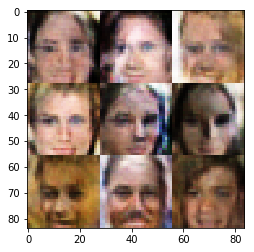

Epoch 0/1... Discriminator Loss: 1.2296... Generator Loss: 0.7589
Epoch 0/1... Discriminator Loss: 1.2595... Generator Loss: 0.7085
Epoch 0/1... Discriminator Loss: 1.2622... Generator Loss: 0.8044
Epoch 0/1... Discriminator Loss: 1.2179... Generator Loss: 1.2083
Epoch 0/1... Discriminator Loss: 1.1378... Generator Loss: 0.7858
Epoch 0/1... Discriminator Loss: 1.1968... Generator Loss: 0.7839
Epoch 0/1... Discriminator Loss: 1.5820... Generator Loss: 0.3953
Epoch 0/1... Discriminator Loss: 1.3782... Generator Loss: 0.7240
Epoch 0/1... Discriminator Loss: 1.2230... Generator Loss: 0.8294
Epoch 0/1... Discriminator Loss: 1.1741... Generator Loss: 0.8534


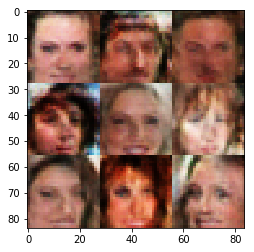

Epoch 0/1... Discriminator Loss: 1.7503... Generator Loss: 0.3139
Epoch 0/1... Discriminator Loss: 1.2006... Generator Loss: 0.8016
Epoch 0/1... Discriminator Loss: 1.3073... Generator Loss: 0.6111
Epoch 0/1... Discriminator Loss: 1.2551... Generator Loss: 0.7419
Epoch 0/1... Discriminator Loss: 1.2060... Generator Loss: 1.3253
Epoch 0/1... Discriminator Loss: 1.2011... Generator Loss: 0.7555
Epoch 0/1... Discriminator Loss: 1.4354... Generator Loss: 1.5650
Epoch 0/1... Discriminator Loss: 1.2112... Generator Loss: 0.8304
Epoch 0/1... Discriminator Loss: 1.2672... Generator Loss: 1.2786
Epoch 0/1... Discriminator Loss: 1.2715... Generator Loss: 0.7436


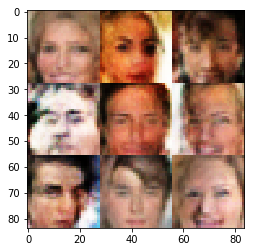

Epoch 0/1... Discriminator Loss: 1.2167... Generator Loss: 0.9553
Epoch 0/1... Discriminator Loss: 1.3140... Generator Loss: 0.6736
Epoch 0/1... Discriminator Loss: 1.2616... Generator Loss: 1.3589
Epoch 0/1... Discriminator Loss: 1.3078... Generator Loss: 0.6656
Epoch 0/1... Discriminator Loss: 1.3383... Generator Loss: 0.8639
Epoch 0/1... Discriminator Loss: 1.4141... Generator Loss: 0.5938
Epoch 0/1... Discriminator Loss: 1.4543... Generator Loss: 0.5339
Epoch 0/1... Discriminator Loss: 1.1958... Generator Loss: 0.8701
Epoch 0/1... Discriminator Loss: 1.3499... Generator Loss: 0.8819
Epoch 0/1... Discriminator Loss: 1.2494... Generator Loss: 0.9455


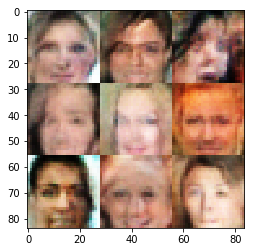

Epoch 0/1... Discriminator Loss: 1.3089... Generator Loss: 0.6591
Epoch 0/1... Discriminator Loss: 1.1932... Generator Loss: 1.4061
Epoch 0/1... Discriminator Loss: 1.3337... Generator Loss: 0.7444
Epoch 0/1... Discriminator Loss: 1.0917... Generator Loss: 1.0685
Epoch 0/1... Discriminator Loss: 1.3432... Generator Loss: 1.0049
Epoch 0/1... Discriminator Loss: 1.2890... Generator Loss: 0.7170


In [14]:
batch_size = 64
z_dim = 100
learning_rate = (math.e * 2) ** (-4)
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.